In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
os.getcwd()

'C:\\Users\\minha\\Github\\signaling-systems\\trajectories'

In [3]:
os.listdir('D:\\Data\\hoffmanlab\\lstmtimeseries\\data2')

['time_series_ktr_CpG_R1_Dose_6.csv',
 'time_series_ktr_CpG_R2_Dose_6.csv',
 'time_series_ktr_LPS_R1_Dose_6.csv',
 'time_series_ktr_LPS_R2_Dose_6.csv',
 'time_series_ktr_P3C4_R1_Dose_6.csv',
 'time_series_ktr_P3C4_R2_Dose_6.csv',
 'time_series_ktr_TNF_R1_Dose_6.csv',
 'time_series_ktr_TNF_R2_Dose_6.csv']

In [4]:
def create_dataset(path, file_names, label_list, remove_nans=True):
    dataset, data, labels = [], [], []
    # import pdb; pdb.set_trace()
    for l, i in zip(label_list, file_names):
        df = pd.read_csv(path + i, header=None)
        num_features, num_data = df.columns[-1], len(df)
        df[num_features + 1] = np.repeat(l, num_data) # add labels to the last column
        npd = np.array(df)
        dataset.append(npd)
        data.append(npd[:, :num_features + 1])
        labels.append(npd[:, num_features + 1])
    
    dataset = np.concatenate(dataset)
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    
    if remove_nans:
        non_nans = ~np.isnan(dataset).any(axis=1)
        dataset = dataset[non_nans]
        data = data[non_nans]
        labels = labels[non_nans]
    
    assert len(data) == len(labels) == len(dataset)
    
    return dataset, data, labels

In [5]:
dataset, data, labels = create_dataset('D:\\Data\\hoffmanlab\\lstmtimeseries\\data2\\', 
                                       os.listdir('D:\\Data\\hoffmanlab\\lstmtimeseries\\data2'), 
                                       [0, 0, 1, 1, 2, 2, 3, 3])

In [6]:
def standard_scale(data):
    scaler = StandardScaler()
    scaler.fit(data[:, :95])
    data[:, :95] = scaler.transform(data[:, :95])
    return data

In [7]:
print(len(dataset), len(data), len(labels))
print(len(dataset) * 0.9, len(dataset) * 0.1)

4018 4018 4018
3616.2000000000003 401.8


In [8]:
dataset = standard_scale(dataset)

In [9]:
X, y = torch.utils.data.random_split(dataset, [3616, 402])
trainloader = torch.utils.data.DataLoader(X, shuffle=True, batch_size=64)
valloader = torch.utils.data.DataLoader(y, shuffle=True, batch_size=64)

In [40]:
class TSC(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, linear_hd1, linear_hd2):
        super().__init__()
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # self.linear1 = nn.Linear(num_layers * hidden_dim, linear_hd1)
        # self.linear2 = nn.Linear(linear_hd1, linear_hd2)
        # self.linear3 = nn.Linear(linear_hd2, output_dim)
        self.linear1 = nn.Linear(num_layers * hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
        torch.nn.init.orthogonal_(self.lstm.weight_ih_l0)
        # torch.nn.init.orthogonal_(self.lstm.weight_ih_l1)
        
    def forward(self, x):
        _, (h, c) = self.lstm(x)
        h = h.permute(1, 0, 2).flatten(start_dim=1)
        # out = self.linear3(self.linear2(self.linear1(h)))
        out = self.linear1(h)
        return out

In [49]:
device = torch.device('cuda:0')
model = TSC(input_dim=1, hidden_dim=95, output_dim=4, num_layers=1, linear_hd1=512, linear_hd2=256).to(device)
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss = nn.CrossEntropyLoss()

In [59]:
avg_epoch_t_loss = []
avg_epoch_v_loss = []
avg_t_loss = []
avg_v_loss = []
avg_acc = []

In [68]:
np.where(np.diff(avg_epoch_v_loss) < 0)

(array([  1,   2,   5,   8,   9,  12,  16,  18,  19,  22,  24,  29,  30,
         31,  32,  35,  38,  41,  42,  43,  44,  45,  47,  50,  51,  53,
         58,  59,  61,  63,  64,  67,  68,  69,  70,  72,  73,  77,  79,
         80,  82,  83,  85,  87,  89,  90,  91,  92,  93,  94,  95,  97,
         99, 100, 102, 103, 105, 106, 108, 109, 110, 111, 112, 115, 120,
        122, 124, 126, 128, 129, 131, 132, 135, 137, 139, 140, 141, 143,
        146, 148, 150, 151, 153, 155, 156, 157, 159, 160, 163, 165, 166,
        169, 171, 173, 176, 178, 180, 181, 183, 185, 187, 190, 191, 193,
        195, 198, 202, 203, 207, 209, 210, 212, 213, 214, 216, 218, 219,
        221, 223, 225, 226, 228, 229, 231, 233, 234, 236, 238, 241, 243,
        244, 246, 247, 249, 251, 252, 253, 256, 258, 260, 262, 264, 266,
        268, 270, 275, 278, 280, 282, 283, 285, 286, 288, 291, 294, 296,
        297, 301, 302, 303, 305, 307, 310, 311, 314, 315, 319, 320, 322,
        324, 328, 329, 332, 333, 335, 336, 338, 339

In [63]:
for e in range(200):
    t_loss, v_loss, acc = [], [], []
    for d in trainloader:
        x = d[:, :95].unsqueeze(-1).float().to(device)
        y = d[:, 95].long().to(device)
        
        pred = model(x)
        l = loss(pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        # lr_scheduler.step(l)
        
        t_loss.append(l.detach().cpu().numpy())
    
    for d in valloader:
        x = d[:, :95].unsqueeze(-1).float().to(device)
        y = d[:, 95].long().to(device)
        
        pred = model(x)
        l = loss(pred, y)
        
        class_pred = torch.argmax(F.softmax(pred, dim=1), dim=1)
        a = sum(class_pred == y) / len(y)
        acc.append(a)
        
        v_loss.append(l.detach().cpu().numpy())
        
    avg_epoch_t_loss.append(np.mean(t_loss))
    avg_epoch_v_loss.append(np.mean(v_loss))
    avg_acc.append(torch.mean(torch.Tensor(acc)))
    
    avg_t_loss.append(np.mean(avg_epoch_t_loss))
    avg_v_loss.append(np.mean(avg_epoch_v_loss))
    
    print(f'Epoch: {e}, Train Loss: {avg_t_loss[-1]}, Val Loss: {avg_v_loss[-1]}, Acc: {avg_acc[-1]}')

Epoch: 0, Train Loss: 0.9578641057014465, Val Loss: 1.0194131135940552, Acc: 0.6765872836112976
Epoch: 1, Train Loss: 0.9566251039505005, Val Loss: 1.018378734588623, Acc: 0.6924603581428528
Epoch: 2, Train Loss: 0.9552866220474243, Val Loss: 1.0174596309661865, Acc: 0.6877480149269104
Epoch: 3, Train Loss: 0.9539271593093872, Val Loss: 1.016663670539856, Acc: 0.6919642686843872
Epoch: 4, Train Loss: 0.9525730013847351, Val Loss: 1.0159902572631836, Acc: 0.664434552192688
Epoch: 5, Train Loss: 0.951278805732727, Val Loss: 1.0154742002487183, Acc: 0.6604662537574768
Epoch: 6, Train Loss: 0.9499537944793701, Val Loss: 1.0145206451416016, Acc: 0.7237103581428528
Epoch: 7, Train Loss: 0.9486398100852966, Val Loss: 1.0136710405349731, Acc: 0.6770833134651184
Epoch: 8, Train Loss: 0.9473389387130737, Val Loss: 1.0130879878997803, Acc: 0.6753472089767456
Epoch: 9, Train Loss: 0.9461128115653992, Val Loss: 1.0121972560882568, Acc: 0.69692462682724
Epoch: 10, Train Loss: 0.9447743892669678, Val

KeyboardInterrupt: 

In [61]:
pred

tensor([[ 2.9388e-01, -6.3096e-01, -2.1956e-01,  3.6226e-01],
        [ 3.4964e-01, -8.8640e-01, -1.7534e-01,  5.0390e-01],
        [ 2.8530e-01, -4.7131e-01, -2.6719e-01,  2.6254e-01],
        [ 2.9714e-01, -6.8225e-01,  1.5726e-02,  4.2992e-01],
        [ 4.1422e-02, -1.4457e-01, -1.7001e-01,  4.1423e-02],
        [ 2.2803e-01, -5.1403e-01, -3.4408e-02,  3.1265e-01],
        [ 3.3422e-01, -8.4905e-01, -1.7949e-01,  4.8205e-01],
        [ 3.4532e-01, -8.9207e-01, -1.6941e-01,  5.0513e-01],
        [-5.9063e-02,  2.0302e-01, -2.3633e-01, -1.9262e-01],
        [ 2.9323e-01, -6.5124e-01, -2.1118e-01,  3.7317e-01],
        [ 2.9875e-01, -6.5243e-01, -2.2001e-01,  3.7545e-01],
        [ 1.8716e-01, -1.6176e-01, -1.3819e-01,  9.4613e-02],
        [-6.5201e-02,  3.4087e-01, -2.7101e-01, -2.7572e-01],
        [ 3.5651e-01, -9.6306e-01, -1.5031e-01,  5.3882e-01],
        [-4.6810e-02,  4.3606e-01, -3.3866e-01, -3.3819e-01],
        [-3.8148e-03,  2.9954e-01, -2.6336e-01, -2.3678e-01],
        

In [26]:
F.softmax(pred, dim=1)

tensor([[0.3303, 0.1410, 0.2109, 0.3178],
        [0.2477, 0.4664, 0.1833, 0.1027],
        [0.2312, 0.3286, 0.2427, 0.1974],
        [0.2505, 0.4838, 0.1760, 0.0897],
        [0.2147, 0.0815, 0.2044, 0.4994],
        [0.3252, 0.3008, 0.2013, 0.1727],
        [0.2412, 0.3653, 0.2238, 0.1697],
        [0.2382, 0.3528, 0.2302, 0.1787],
        [0.2536, 0.4922, 0.1885, 0.0658],
        [0.1199, 0.6673, 0.1631, 0.0497],
        [0.2485, 0.4051, 0.2062, 0.1402],
        [0.2488, 0.4142, 0.2029, 0.1341],
        [0.2337, 0.3355, 0.2389, 0.1920],
        [0.2398, 0.3619, 0.2263, 0.1720],
        [0.2445, 0.3765, 0.2182, 0.1609],
        [0.2250, 0.3168, 0.2520, 0.2061],
        [0.2424, 0.1107, 0.2095, 0.4373],
        [0.3030, 0.1088, 0.2132, 0.3749],
        [0.3096, 0.1169, 0.2127, 0.3609],
        [0.2358, 0.1028, 0.2080, 0.4534],
        [0.2415, 0.3609, 0.2249, 0.1727],
        [0.3197, 0.1249, 0.2112, 0.3442],
        [0.2448, 0.3793, 0.2170, 0.1589],
        [0.2508, 0.4366, 0.1940, 0

In [27]:
torch.argmax(F.softmax(pred, dim=1), dim=1)

tensor([0, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1,
        1, 1, 3, 1, 0, 1, 3, 3, 1, 1, 1, 1, 3, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
        3, 3, 3, 1, 3, 1, 1, 0, 1, 3, 3, 3, 1, 1, 1, 1], device='cuda:0')

In [28]:
y

tensor([3, 2, 1, 1, 3, 1, 0, 1, 3, 2, 3, 1, 1, 0, 3, 3, 3, 3, 0, 2, 1, 3, 3, 0,
        0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 1, 2, 0, 1,
        1, 1, 2, 1, 2, 0, 1, 2, 3, 2, 1, 1, 1, 0, 3, 0], device='cuda:0')

In [73]:
sum(torch.argmax(F.softmax(pred, dim=1), dim=1) == y) / len(y)

tensor(0.9062, device='cuda:0')

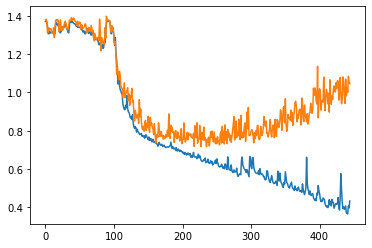

In [65]:
plt.plot(avg_epoch_t_loss)
plt.plot(avg_epoch_v_loss)

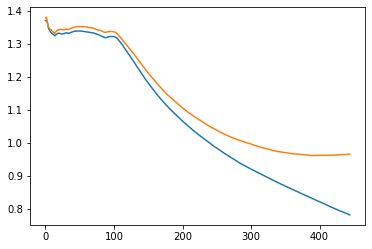

In [64]:
plt.plot(avg_t_loss)
plt.plot(avg_v_loss)

In [45]:
model.eval()
print('..')

..


In [46]:
acc_list = []
for d in valloader:
    x, y = d[:, :95].unsqueeze(-1).float().to(device), d[:, 95].long().to(device)
    pred = model(x)
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1)
    
    acc = sum(pred == y) / len(y)
    acc_list.append(acc)

In [47]:
torch.mean(torch.Tensor(acc_list))

tensor(0.5156)

In [199]:
torch.save({'model': model.state_dict(),
            'optim': optimizer.state_dict()},
           'weights/2.pth')

In [574]:
# X, y = torch.utils.data.random_split(scaled_dataset, [3616, 402])
# trainloader = torch.utils.data.DataLoader(X, shuffle=True, batch_size=32)
# valloader = torch.utils.data.DataLoader(y, shuffle=True, batch_size=32)

In [644]:
class TSC(nn.Module): # time-series classifier
    def __init__(self, input_size, hidden_size, num_layers, linear_hs1, linear_hs2, output_size): # output_size = num_classes
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.LSTM = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.linear1 = nn.Linear(hidden_size * num_layers, linear_hs1)
        # self.linear2 = nn.Linear(linear_hs1, linear_hs2)
        # self.linear3 = nn.Linear(linear_hs2, output_size)
        self.linear = nn.Linear(hidden_size * num_layers, output_size)
        self.relu = nn.ReLU()
        
        self.device = torch.device('cuda:0')
        
        # init weights
        # torch.nn.init.xavier_uniform(self.LSTM.weight)
        # torch.nn.init.xavier_uniform_(self.linear1.weight)
        # torch.nn.init.xavier_uniform_(self.linear2.weight)
        # torch.nn.init.xavier_uniform_(self.linear3.weight)
        torch.nn.init.xavier_uniform_(self.linear.weight)
        
    def forward(self, x): # i.e [b, seq_len, dim] = [b, 95, 2]
        batch_size = x.size(0)
#         h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size, dtype=torch.float32).requires_grad_() # num layers, B (batch size), H1 (hidden size)
#         c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size, dtype=torch.float32).requires_grad_()
#         h0 = h0.to(self.device)
#         c0 = c0.to(self.device)
        
#         out, (h, c) = self.LSTM(x, (h0.detach(), c0.detach())) # h0, c0 initializes to 0s if not provided
        
        # h = h.permute(1, 0, 2)
        # h = h.flatten(start_dim=1)
        # out = self.linear3(self.linear2(self.linear1(h)))
        
        # h = self.relu(h)
        # h = self.relu(self.linear1(h))
        # h = self.relu(self.linear2(h))
        # out = self.linear3(h)
        
        # out = out.flatten(start_dim=1)
        # out = self.relu(out)
        # out = self.relu(self.linear1(out))
        # out = self.relu(self.linear2(out))
        # out = self.linear3(out)
        
        # out = out.permute(1, 0, 2) # [b, 95, 95] -> [95, b, 95]
        # out = out[-1] # [b, 95]
        # out = self.linear3(self.linear2(self.linear1(out)))
        
        # h = h.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        # out = self.linear3(self.linear2(self.linear1(h)))
        
        _, (h, c) = self.LSTM(x)
        h = h.permute(1, 0, 2)
        h = h.flatten(start_dim=1)
        # h = self.relu(self.linear1(self.relu(h)))
        # h = self.relu(self.linear2(h))
        # out = self.linear3(h)
        out = self.linear(self.relu(h))
        
        out = F.softmax(out, dim=-1) # convert to class probabilities
        return out

In [511]:
data = data[~np.isnan(data).any(axis=1), :]

In [520]:
print(np.where(dataset[:, [95]].reshape(-1, ) == 0)[0][-1])
print(np.where(dataset[:, [95]].reshape(-1, ) == 1)[0][-1])
print(np.where(dataset[:, [95]].reshape(-1, ) == 2)[0][-1])

1147
2100
2981


In [521]:
# CpG, LPS, P3C4, TNF
cpg = data[:1148]
lps = data[1148:2101]
p3c4 = data[2101:2982]
tnf = data[2982:]

In [522]:
np.mean(cpg, axis=0).shape

(95,)

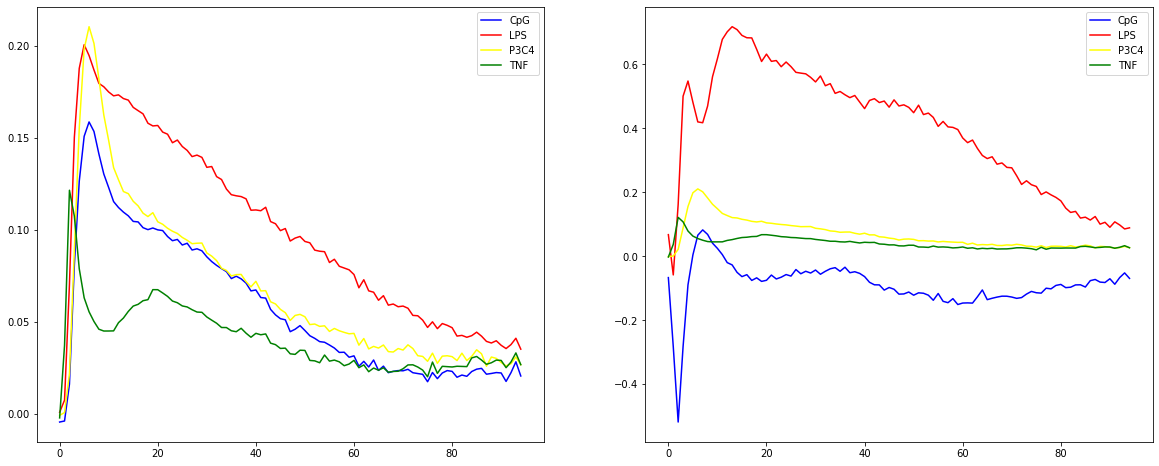

In [548]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].plot(np.mean(cpg, axis=0), color='blue', label='CpG')
ax[0].plot(np.mean(lps, axis=0), color='red', label='LPS')
ax[0].plot(np.mean(p3c4, axis=0), color='yellow', label='P3C4')
ax[0].plot(np.mean(tnf, axis=0), color='green', label='TNF')

ax[0].legend()

ax[1].plot(np.mean(cpg_scaled, axis=0), color='blue', label='CpG')
ax[1].plot(np.mean(lps_scaled, axis=0), color='red', label='LPS')
ax[1].plot(np.mean(p3c4, axis=0), color='yellow', label='P3C4')
ax[1].plot(np.mean(tnf, axis=0), color='green', label='TNF')

ax[1].legend()

In [532]:
from sklearn.preprocessing import StandardScaler

In [537]:
scaler = StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

In [539]:
cpg_scaled = scaled_data[:1148]
lps_scaled = scaled_data[1148:2101]
p3c4_scaled = scaled_data[2101:2982]
tnf_scaled = scaled_data[2982:]

In [380]:
plt.bar(np.unique(labels), [sum(labels == i) for i in np.unique(labels)])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

## Training Loop

In [660]:
# parameters
input_size = 1 # dimension of sequence
hidden_size = 95
num_layers = 3
linear_hs1 = 512
linear_hs2 = 256
output_size = 4
lr = 1e-2
batch_size = 32
epochs = 100

In [661]:
# model parameters
device = torch.device('cuda:0')
model = TSC(input_size, hidden_size, num_layers, linear_hs1, linear_hs2, output_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr)
loss = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [662]:
avg_train_loss = []
avg_val_loss = []

In [663]:
for e in range(epochs + 1000):
    epoch_train_loss = []
    epoch_val_loss = []
    
    for x in trainloader:
        data = x[:, :95].unsqueeze(-1).float().to(device)
        labels = x[:, 95].long().to(device)
        # labels = F.one_hot(labels.long(), num_classes=4).float()
        
        pred = model(data)
        l = loss(pred, labels)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        lr_scheduler.step(l)
        
        epoch_train_loss.append(l.detach().cpu().numpy())
        
    for x in valloader:
        data = x[:, :95].unsqueeze(-1).float().to(device)
        labels = x[:, 95].long().to(device)
        # labels = F.one_hot(labels.long(), num_classes=4).float()
        
        pred = model(data)
        l = loss(pred, labels)
        
        epoch_val_loss.append(l.detach().cpu().numpy())
        
    avg_train_loss.append(np.mean(epoch_train_loss))
    avg_val_loss.append(np.mean(epoch_val_loss))
    
    print(f'Epoch: {e}, Epoch Train Loss: {avg_train_loss[-1]}, Epoch Val Loss: {avg_val_loss[-1]}, Avg Train Loss: {np.mean(avg_train_loss)}, Avg Val Loss: {np.mean(avg_val_loss)}')

Epoch: 0, Epoch Train Loss: 1.4106475114822388, Epoch Val Loss: 1.4037678241729736, Avg Train Loss: 1.4106475114822388, Avg Val Loss: 1.4037678241729736
Epoch: 1, Epoch Train Loss: 1.406439185142517, Epoch Val Loss: 1.4111533164978027, Avg Train Loss: 1.408543348312378, Avg Val Loss: 1.4074605703353882
Epoch: 2, Epoch Train Loss: 1.4064362049102783, Epoch Val Loss: 1.4048504829406738, Avg Train Loss: 1.4078410863876343, Avg Val Loss: 1.406590461730957
Epoch: 3, Epoch Train Loss: 1.4064332246780396, Epoch Val Loss: 1.4130566120147705, Avg Train Loss: 1.4074890613555908, Avg Val Loss: 1.4082069396972656
Epoch: 4, Epoch Train Loss: 1.4064302444458008, Epoch Val Loss: 1.4074645042419434, Avg Train Loss: 1.4072773456573486, Avg Val Loss: 1.4080584049224854
Epoch: 5, Epoch Train Loss: 1.406427025794983, Epoch Val Loss: 1.4049166440963745, Avg Train Loss: 1.4071356058120728, Avg Val Loss: 1.4075347185134888
Epoch: 6, Epoch Train Loss: 1.4064240455627441, Epoch Val Loss: 1.4063162803649902, Av

KeyboardInterrupt: 

In [664]:
pred

tensor([[6.8159e-01, 3.1462e-01, 3.6791e-03, 1.1244e-04],
        [6.6782e-01, 3.2784e-01, 4.2069e-03, 1.3003e-04],
        [6.7539e-01, 3.2060e-01, 3.8957e-03, 1.1896e-04],
        [6.7240e-01, 3.2344e-01, 4.0371e-03, 1.2576e-04],
        [6.7393e-01, 3.2205e-01, 3.8962e-03, 1.1987e-04],
        [6.7048e-01, 3.2527e-01, 4.1205e-03, 1.2641e-04],
        [6.7381e-01, 3.2215e-01, 3.9247e-03, 1.2099e-04],
        [6.6852e-01, 3.2713e-01, 4.2236e-03, 1.2736e-04],
        [6.6745e-01, 3.2818e-01, 4.2336e-03, 1.3012e-04],
        [6.8082e-01, 3.1536e-01, 3.7041e-03, 1.1446e-04],
        [6.7404e-01, 3.2196e-01, 3.8783e-03, 1.1962e-04],
        [6.7206e-01, 3.2379e-01, 4.0160e-03, 1.2428e-04],
        [6.7337e-01, 3.2251e-01, 3.9937e-03, 1.2404e-04],
        [6.7061e-01, 3.2516e-01, 4.1050e-03, 1.2754e-04],
        [6.7006e-01, 3.2572e-01, 4.0910e-03, 1.2788e-04],
        [6.7400e-01, 3.2194e-01, 3.9324e-03, 1.2126e-04],
        [6.7189e-01, 3.2396e-01, 4.0294e-03, 1.2392e-04],
        [6.770

In [630]:
labels

tensor([0, 0, 1, 2, 0, 2, 0, 1, 1, 0, 2, 2, 2, 3, 0, 0, 2, 1, 1, 0, 2, 0, 2, 1,
        3, 2, 1, 2, 1, 1, 3, 0], device='cuda:0')

In [602]:
label = x[:, 95]
data = x[:, :95]

In [607]:
predx = model(data.unsqueeze(-1).float().to(device))

In [611]:
label  = label.to(device)

In [613]:
loss(predx, label.long())

tensor(1.3899, device='cuda:0', grad_fn=<NllLossBackward0>)

In [614]:
ohlabel = (F.one_hot(label.long(), num_classes=4).float())

In [616]:
loss(predx, ohlabel)

tensor(1.3899, device='cuda:0', grad_fn=<DivBackward1>)

In [599]:
pred

tensor([[0.3780, 0.2526, 0.1381, 0.2313],
        [0.3934, 0.2437, 0.1345, 0.2284],
        [0.3551, 0.2675, 0.1447, 0.2326],
        [0.3540, 0.2686, 0.1450, 0.2323],
        [0.4038, 0.2384, 0.1317, 0.2261],
        [0.3574, 0.2661, 0.1435, 0.2329],
        [0.3769, 0.2531, 0.1385, 0.2315],
        [0.3756, 0.2528, 0.1397, 0.2319],
        [0.4417, 0.2201, 0.1257, 0.2126],
        [0.4300, 0.2249, 0.1268, 0.2182],
        [0.4128, 0.2331, 0.1301, 0.2239],
        [0.4732, 0.1999, 0.1434, 0.1835],
        [0.4186, 0.2304, 0.1287, 0.2223],
        [0.3819, 0.2501, 0.1373, 0.2307],
        [0.4237, 0.2279, 0.1278, 0.2206],
        [0.3773, 0.2527, 0.1385, 0.2315],
        [0.4415, 0.2196, 0.1264, 0.2126],
        [0.4225, 0.2283, 0.1282, 0.2211],
        [0.3983, 0.2410, 0.1333, 0.2274],
        [0.4014, 0.2396, 0.1324, 0.2266],
        [0.3804, 0.2512, 0.1374, 0.2309],
        [0.3522, 0.2703, 0.1457, 0.2318],
        [0.3721, 0.2559, 0.1397, 0.2323],
        [0.4101, 0.2349, 0.1305, 0

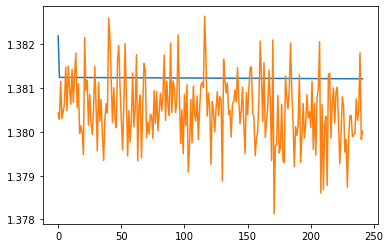

In [594]:
plt.plot(avg_train_loss)
plt.plot(avg_val_loss)

In [582]:
labels

tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]], device='cuda:0')

In [ ]:
out, (h, c) = model.LSTM(data)

In [440]:
out[0][-1].shape

torch.Size([95])

In [416]:
labels

tensor([[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]], device='cuda:0')

In [ ]:
dataset[:, 95]

In [235]:
yur = nn.LSTM(1, 95, 2)

In [236]:
lol = yur(torch.rand(5, 95, 1))

In [237]:
lol[0].shape

torch.Size([5, 95, 95])

In [224]:
torch.rand(4, 4, 95)[-1].shape

torch.Size([4, 95])